# Deep Learning &mdash; Assignment 1

First assignment for the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_September 2022_

-----

**Names:** Hauque Federico Gabriel, Soler Sanz Guillem

**Group:** Nº5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Experiment with gradient descent optimization;
2. Derive and implement gradients for binary cross-entropy loss, the sigmoid function and a linear layer;
3. Test your gradient implementations with the finite difference method;
4. Use these components to implement and train a simple neural network.

In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize
import sklearn.datasets
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

# 1.1 Gradient descent optimization (5 points)

Consider the following function with two parameters and its derivatives:
\begin{align}
  f(x, y) &= x^2 + y^2 + x (y + 2) + \cos(3x) \\
  \frac{\partial f}{\partial x} &= 2x - 3\sin(3x) + y + 2 \\
  \frac{\partial f}{\partial y} &= x + 2y \\
\end{align}

In [2]:
def f(x, y):
    return x ** 2 + y ** 2 + x * (y + 2) + np.cos(3 * x)
def grad_x_f(x, y):
    return 2 * x - 3 * np.sin(3 * x) + y + 2
def grad_y_f(x, y):
    return x + 2 * y

A plot of the function shows that it has multiple local minima:

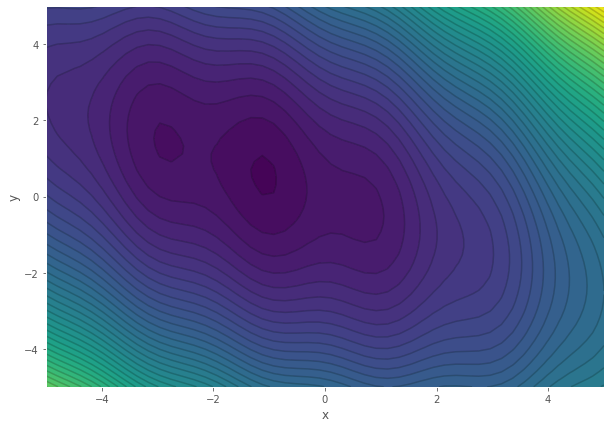

In [3]:
def plot_f_contours():
    xx, yy = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
    zz = f(xx, yy)
    plt.contourf(xx, yy, zz, 50)
    plt.contour(xx, yy, zz, 50, alpha=0.2, colors='black', linestyles='solid')
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(10, 7))
plot_f_contours()

### Implement gradient descent

We would like to find the minimum of this function using gradient descent.

**(a)<span style="float:right"> (1 point)</span> Implement the gradient descent updates for $x$ and $y$ in the function below:**

In [4]:
def optimize_f(x, y, step_size, steps):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at the current point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x = x - (step_size * dx)
        y = y - (step_size * dy)

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

### Tune the parameters

We will now try if our optimization method works.

Use this helper function to plot the results:

In [5]:
# helper function that plots the results of the gradient descent optimization
def plot_gradient_descent_results(x, y, val, x_hist, y_hist):
    # plot the path on the contour plot
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plot_f_contours()
    plt.plot(x_hist, y_hist, '.-')
    
    # plot the learning curve
    plt.subplot(1, 2, 2)
    plt.plot(f(np.array(x_hist), np.array(y_hist)), '.r-')
    plt.title('Minimum value: %f' % f(x_hist[-1], y_hist[-1]))

**(b) Run the gradient descent optimization with the following initial settings:**

``x=3, y=2, step_size=0.1, steps=10``

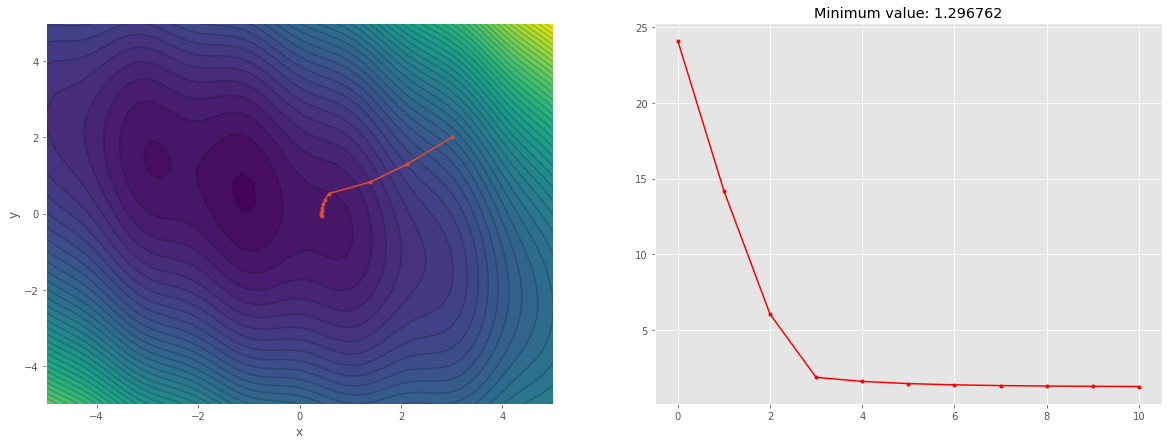

In [6]:
results = optimize_f(x=3, y=2, step_size=0.1, steps=10)
plot_gradient_descent_results(*results)

**(c)<span style="float:right"> (1 point)</span> Does it find the minimum of the function? What happens?**

No, it starts very far from the actual minimum and appears to get caught in a local one instead of the actual global minimum.

**(d) Try a few different values for the `step_size` and the number of `steps` to get close to the optimal solution:**

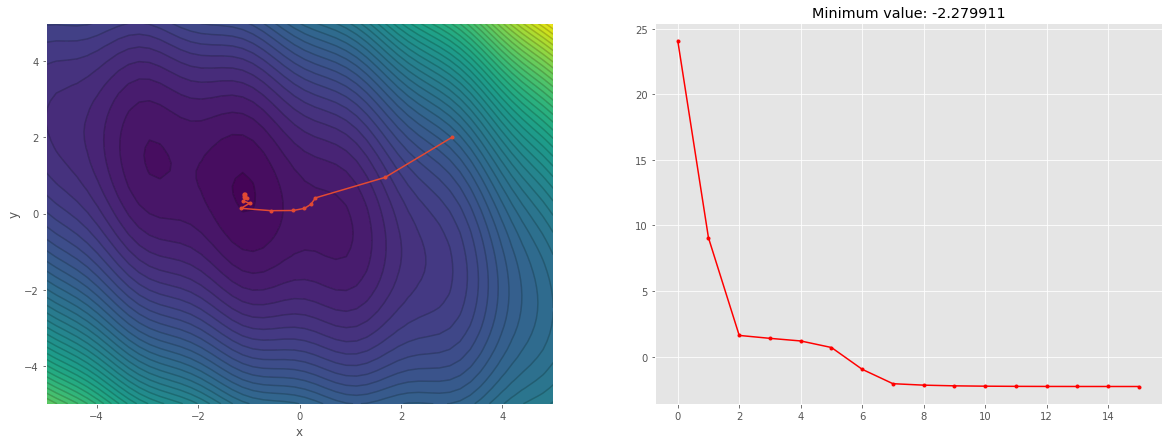

In [7]:
results = optimize_f(x=3, y=2, step_size=0.15, steps=15)
plot_gradient_descent_results(*results)

**(e) Were you able to find a step size that reached the global optimum? If not, why not? What happens if you set the step size too large or too small?<span style="float:right"> (1 point)</span>**

It depends on the starting position. 
If you begin too far from the minimum, the small step sizes will not be enough to reach that point. Big ones will instead get a lot faster to a relatively closer position to the minimum.
If you begin near to the minimum, big step sizes will guess moving far from the objective, and in some cases it could actually mean getting an even worse result than with the starting point.

### Implement a decreasing step size

You might get better results if you use a step size that is large at the beginning, but slowly decreases during the optimization.

Try the following scheme to compute the step size $\eta_t$ in step $t$, given a decay parameter $d$:
\begin{align}
  \eta_t = \eta_0 d^t
\end{align}

**(f) Update your optimization function to use this step size schedule:<span style="float:right"> (1 point)</span>**

In [8]:
def optimize_f(x, y, step_size, steps, decay=1.0):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at this point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x = x - ((step_size * decay) * dx)
        y = y - ((step_size * decay) * dy)

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

**(g) Tune the `step_sizes`, `steps` and `decay` parameters to get closer to the global minimum:<span style="float:right"> (1 point)</span>**

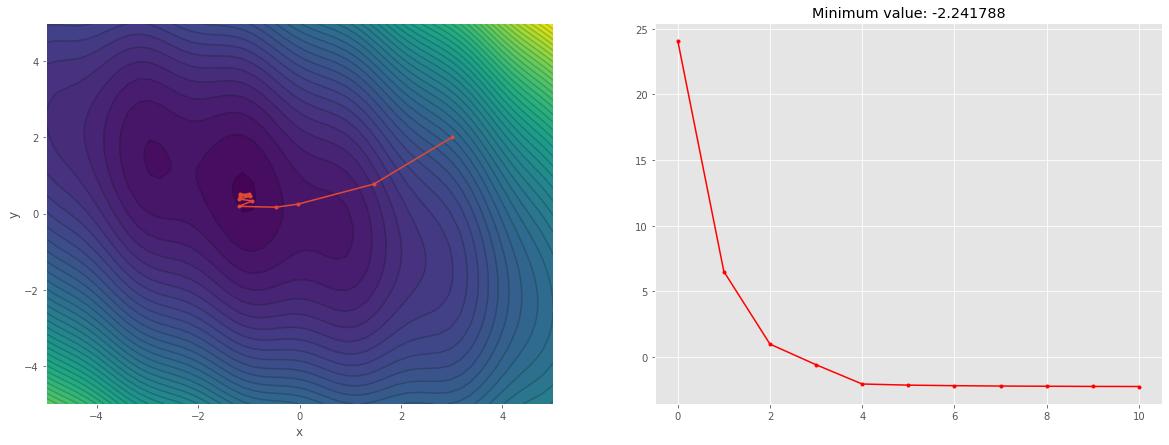

In [9]:
results = optimize_f(x=3, y=2, step_size=0.25, steps=10, decay=0.7)
plot_gradient_descent_results(*results)

We will now look at some more complex functions that we can try to optimize.

## 1.2 Neural network components (17 points)

In this assignment, we will implement a simple neural network from scratch. We need four components:
1. A sigmoid activation function,
2. A ReLU activation function,
3. A binary cross-entropy loss function,
4. A linear layer.

For each component, we will implement the forward pass, the backward pass, and the gradient descent update.

### Sigmoid non-linearity

The sigmoid function is defined as:

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\end{align}

![Sigmoid](attachment:sigmoid.png)

**(a) Give the derivative of the sigmoid function:<span style="float:right"> (1 point)</span>**

\begin{align}
\frac{\partial \sigma(x)}{\partial x} &= \frac{e^{-x}}{(1 + e^{-x})^2}
\end{align}

**(b) Implement the sigmoid and its gradient in the functions `sigmoid(x)` and `sigmoid_grad(x)`:<span style="float:right"> (2 points)</span>**

In [11]:
def sigmoid(x):
    return 1 / ( 1 + (np.e)**(-x) )

def sigmoid_grad(x):
    return (np.e)**(-x) / ( 1 + (np.e)**(-x) )**2

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('sigmoid(x):', sigmoid(x))
print('sigmoid_grad(x):', sigmoid_grad(x))

x: [-5.440675  6.964323  6.638147 -1.068075 -7.132789]
sigmoid(x): [0.004318 0.999056 0.998692 0.255769 0.000798]
sigmoid_grad(x): [0.004299 0.000943 0.001306 0.190351 0.000797]


To check that the gradient implementation is correct, we can compute the numerical derivative using the [finite difference](https://en.wikipedia.org/wiki/Finite_difference) method. From [Chapter 11.5 of the Deep Learning book](http://www.deeplearningbook.org/contents/guidelines.html):

> Because
  \begin{align}
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{ \epsilon},
  \end{align}
  we can approximate the derivative by using a small, finite $\epsilon$:
  \begin{align}
    f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}.
  \end{align}
  We can improve the accuracy of the approximation by using the centered difference:
  \begin{align}
    f'(x) \approx \frac{f(x + \frac{1}{2} \epsilon) - f(x - \frac{1}{2} \epsilon)}{\epsilon}.
  \end{align}
  The perturbation size $\epsilon$ must be large enough to ensure that the perturbation is not rounded down too much by ﬁnite-precision numerical computations.

**(c) Use the central difference method to check your implementation of the sigmoid gradient. Compute the numerical gradient and check that it is close to the symbolic gradient computed by your implementation:<span style="float:right"> (1 point)</span>**

In [12]:
# start with some random inputs
x = np.random.uniform(-2, 2, size=5)

# compute the symbolic gradient
print('Symbolic', sigmoid_grad(x))

# compute the numerical gradient
def central_difference(x, perturbation):
    return ( sigmoid( x + ( perturbation / 2 ) ) - sigmoid( x - ( perturbation / 2 ) ) ) / perturbation
print('Central difference',  central_difference(x, 0.1) )
print('Difference between methods:', sigmoid_grad(x) - central_difference(x, 0.1))

Symbolic [0.204054 0.182328 0.187308 0.135114 0.249001]
Central difference [0.204035 0.182321 0.187298 0.135124 0.24895 ]
Difference between methods: [ 0.000019  0.000007  0.00001  -0.000011  0.000051]


**(d) Is the gradient computed with finite differences exactly the same as the analytic answer? Why (not)?<span style="float:right"> (1 point)</span>**

Although it is not exactly the same, it is a very good approximation that becomes more precise when the perturbation value decreases.

**If there is a big difference between the two gradients, please try to make this as small as possible before you continue.**

### Rectified linear units (ReLU)

The rectified linear unit is defined as:
\begin{align}
  f(x) = \max(0, x)
\end{align}

![relu.png](attachment:relu.png)

**(e) Give the derivative of the ReLU function:<span style="float:right"> (1 point)</span>**

\begin{align}
  \frac{\partial f(x)}{\partial x} &= y = 1 \; if \; x > 0 \; | \; y = 0 \; otherwise
\end{align}

**(f) Implement the ReLU function and its gradient in the functions `relu(x)` and `relu_grad(x)`. Use the finite difference method to check that the gradient is correct:<span style="float:right"> (3 points)</span>***

In [13]:
def relu(x):
    return(np.maximum(0,x))

def relu_grad_func(x):
    der = 1 if x > 0 else 0
    return der

def relu_grad(x):
    vfunc = np.vectorize(relu_grad_func)
    return vfunc(x)

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('relu(x):', relu(x))
print('relu_grad(x):', relu_grad(x))
print()

def central_difference(x, perturbation):
    return ( relu( x + ( perturbation / 2 ) ) - relu( x - ( perturbation / 2 ) ) ) / perturbation
print('Central difference',  central_difference(x, 0.5) )
print('Difference between methods:', relu_grad(x) - central_difference(x, 0.5))

x: [ 1.659968 -2.15984  -0.10812   5.010681 -3.001927]
relu(x): [1.659968 0.       0.       5.010681 0.      ]
relu_grad(x): [1 0 0 1 0]

Central difference [1.      0.      0.28376 1.      0.     ]
Difference between methods: [ 0.       0.      -0.28376  0.       0.     ]


### Comparing sigmoid and ReLU

The sigmoid and ReLU activation functions have slightly different characteristics.

**(g) Run the code below to plot the sigmoid and ReLU activation functions and their gradients:**

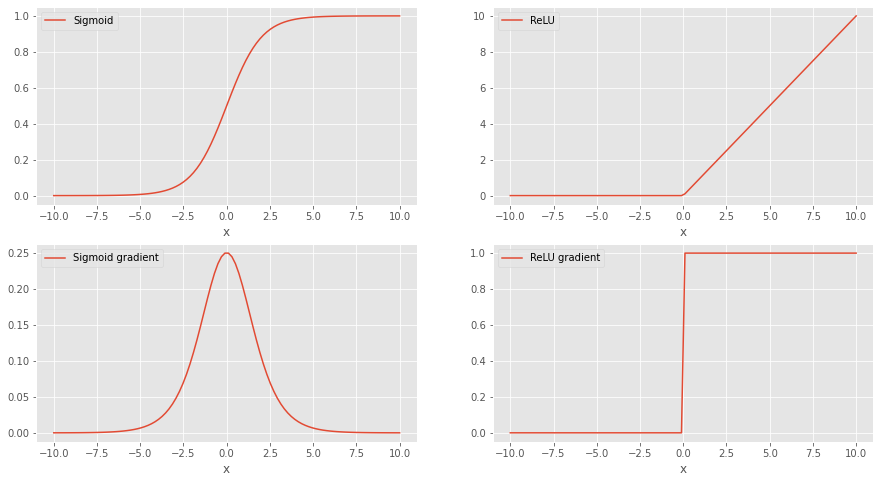

In [14]:
x = np.linspace(-10, 10, 100)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='ReLU')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(x, sigmoid_grad(x), label='Sigmoid gradient')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(x, relu_grad(x), label='ReLU gradient')
plt.xlabel('x')
plt.legend(loc='upper left');

**(h) Which activation function would you recommend for a network that outputs probabilities, i.e., outputs $\in [0, 1]$? Why?<span style="float:right"> (1 point)</span>**

The sigmoid function is the most appropriate to use in this cases since it moves between the range of [0,1], which is exactly the one that is needed for representing probabilities, while RELU keeps growing indefinitely over 1.

**(i) Compare the gradients for sigmoid and ReLU. What are the advantages and disadvantages of each activation function in terms of their gradient?<span style="float:right"> (1 point)</span>**

The sigmoid gardient would be more appropriate when we require a smoother activation, but could be a problem for backpropagation when the gardient is close to 0. The RELU activation function instead, grows faster and never gets back to zero after the origin, so it could be more useful for backpropagation.

### Binary cross-entropy loss

We will use the binary cross-entropy loss to train our network. This loss function is useful for binary classification.

The binary cross-entropy (BCE) is a function of the ground truth label $y \in \{0, 1\}$ and the predicted label $\hat{y} \in [0, 1]$:

\begin{align}
  \mathcal{L} &= -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
\end{align}

To minimize the BCE loss with gradient descent, we need to compute the gradient with respect to the prediction $\hat{y}$.

**(j) Derive the gradient for the BCE loss:<span style="float:right"> (1 point)</span>**

\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{y}} &= \frac{\hat{y}-y}{ln(2)\hat{y}- \hat{y}^{2}ln(2)}
\end{align}

**(k) Implement `bce_loss(y, y_hat)` and `bce_loss_grad(y, y_hat)` and use the finite difference method to check that the gradient is correct:<span style="float:right"> (3 points)</span>**

In [16]:
def bce_loss(y, y_hat):
    return - (y * np.log2(y_hat) + ( ( 1 - y ) * np.log2( 1 - y_hat ) ) )

def bce_loss_grad(y, y_hat):
    return ( ( y_hat - y ) / (np.log(2) * y_hat - np.log(2) * ( y_hat ** 2 ) ) ) 

# try with some random inputs
y = np.random.randint(2, size=5)
y_hat = np.random.uniform(0, 1, size=5)
print('y:', y)
print('y_hat:', y_hat)
print('bceloss(y, y_hat):', bce_loss(y, y_hat))
print()

def central_difference(y, y_hat, perturbation):
    return ( bce_loss( y, y_hat + ( perturbation / 2 ) ) - bce_loss( y, y_hat - ( perturbation / 2 ) ) ) / perturbation
print('Central difference',  central_difference(y, y_hat, 0.001) )
print('Difference between methods:', bce_loss_grad(y, y_hat) - central_difference(y, y_hat, 0.001))

y: [0 0 0 0 0]
y_hat: [0.8139   0.120735 0.147918 0.990934 0.763466]
bceloss(y, y_hat): [2.425847 0.185631 0.230936 6.78527  2.079883]

Central difference [  7.752259   1.640797   1.693142 159.288741   6.099334]
Difference between methods: [-0.000019 -0.       -0.       -0.16162  -0.000009]


### Linear layer

Finally, we need to compute the gradients for the linear layer in our network.

Define a linear model $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$, where
* $\mathbf{x}$ is an input vector of shape $N$,
* $\mathbf{W}$ is a weight matrix of shape $N \times M$,
* $\mathbf{b}$ is a bias vector of shape $M$,
* $\mathbf{y}$ is the output vector of shape $M$.

**(l) Derive the gradients for $\mathbf{y}$ with respect to the input $\mathbf{x}$ and the parameters $\mathbf{W}$ and $\mathbf{b}$:<span style="float:right"> (1 point)</span>**

_Hint: If you have trouble computing this in matrix notation directly, try to do the computation with scalars r notation, writing the linear model as_
\begin{align}
  y_j = \sum_{i=1}^{N} x_i W_{ij} + b_j
\end{align}
where $j$ ranges from $1$ to $M$.

\begin{align}
  \frac{\partial \mathbf{y}}{\partial \mathbf{x}} &= \sum_{i=1}^{N} W_{ij} \\
  \frac{\partial \mathbf{y}}{\partial \mathbf{W}} &= \sum_{i=1}^{N} x_i \\
  \frac{\partial \mathbf{y}}{\partial \mathbf{b}} &=  1 \; if \; i = j \; | \; 0 \; otherwise \\
\end{align}

**(m) Given the gradient $\nabla_\mathbf{y} \mathcal{L}$ for the loss w.r.t. $\mathbf{y}$, use the chain rule to derive the gradients for the loss w.r.t. $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$:<span style="float:right"> (1 point)</span>**

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \frac{\partial \mathbf{L}}{\partial \mathbf{y}} * \frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \frac{\hat{y}-y}{ln(2)\hat{y}- \hat{y}^{2}ln(2)} \sum_{i=1}^{N} W_{ij} \\  \\
  \nabla_\mathbf{W} \mathcal{L} &= \frac{\partial \mathbf{L}}{\partial \mathbf{y}} * \frac{\partial \mathbf{y}}{\partial \mathbf{W}} = \frac{\hat{y}-y}{ln(2)\hat{y}- \hat{y}^{2}ln(2)} \sum_{i=1}^{N} x_i  \\
  \nabla_\mathbf{b} \mathcal{L} &= \frac{\partial \mathbf{L}}{\partial \mathbf{y}} * \frac{\partial \mathbf{y}}{\partial \mathbf{b}} = \frac{\hat{y}-y}{ln(2)\hat{y}- \hat{y}^{2}ln(2)} \\
\end{align}

## 1.3 Implement a one-layer model (2 points)

We can now implement a simple one-layer model with a sigmoid activation:

1. Given an input vector $\mathbf{x}$, weight vector $\mathbf{w}$ and bias $b$, compute the output $\hat{y}$:

\begin{align}
h = \mathbf{x} \mathbf{w}^T + b \\
\hat{y} = \sigma(h) \\
\end{align}

2. Compute the BCE loss comparing the prediction $\hat{y}$ with the ground-truth label $y$.

3. Compute the gradient for the BCE loss and back-propagate this to get $\nabla_\mathbf{x} \mathcal{L}$, the gradient of $\mathcal{L}$ w.r.t. $\mathbf{x}$.

**(a) Complete the implementation below:<span style="float:right"> (2 points)</span>**

In [17]:
# initialize parameters
w = np.random.uniform(size=5)
b = np.random.rand()

# implement the model
def fn(x, y):
    h = x*np.transpose(w) + b
    y_hat = sigmoid(h)
    loss = bce_loss(y, y_hat)
  
    grad_y_hat = bce_loss_grad(y, y_hat)
    grad_h = grad_y_hat * sigmoid_grad(y_hat) 
    grad_x = grad_h * np.transpose(w)
    
    return loss, grad_x

# test with a random input
x = np.random.uniform(size=5)
y = 1

loss, grad_x = fn(x, y)
print("Loss", loss)
print("Gradient", grad_x)

Loss [0.784047 0.58482  0.827745 0.899544 0.904974]
Gradient [-0.137952 -0.311595 -0.162024 -0.04754  -0.273669]


**(b) Use the finite-difference method to check the gradient $\nabla_\mathbf{x} \mathcal{L}$:**

In [18]:
# start with some random inputs
x = np.random.uniform(size=5)
y = 1

# set epsilon to a small value
eps = 0.00001

numerical_grad = np.zeros(x.shape)
# compute the gradient for each element of x separately
for i in range(len(x)):
    # compute inputs at -eps/2 and +eps/2
    x_a, x_b = x.copy(), x.copy()
    x_a[i] += eps / 2
    x_b[i] -= eps / 2

    # compute the gradient for this element
    loss_a, _ = fn(x_a, y)
    loss_b, _ = fn(x_b, y)
    numerical_grad[i] = (loss_a[i] - loss_b[i]) / eps

# compute the symbolic gradient
loss, symbolic_grad = fn(x, y)
    
print("Symbolic gradient")
print(symbolic_grad)
print("Numerical gradient")
print(numerical_grad)

Symbolic gradient
[-0.148024 -0.30902  -0.163644 -0.047319 -0.248545]
Numerical gradient
[-0.157978 -0.304649 -0.174318 -0.050532 -0.263064]


## 1.4 Implement a linear layer and the sigmoid and ReLU activation functions (7 points)

We will now construct a simple neural network. We need to implement the following objects:
* `Linear`: a layer that computes `y = x*W + b`.
* `Sigmoid`: a layer that computes `y = sigmoid(x)`.
* `ReLU`: a layer that computes `y = relu(x)`.

For each layer class, we need to implement the following methods:
* `forward`: The forward pass that computes the output `y` given `x`.
* `backward`: The backward pass that receives the gradient for `y` and computes the gradients for the input `x` and the parameters of the layer.
* `step`: The update step that applies the gradient updates to the parameters of the layer, based on the gradient computed and stored by `backward`.

**(a) Implement a class `Linear` that computes `y = x*W + b`:<span style="float:right"> (3 points)</span>**

In [19]:
# Computes y = x * w + b.
class Linear:
    def __init__(self, n_in, n_out):
        # initialize the weights randomly,
        # using the Xavier initialization rule for scale
        a = np.sqrt(6 / (n_in * n_out))
        self.W = np.random.uniform(-a, a, size=(n_in, n_out))
        self.b = np.zeros((n_out,))

    def forward(self, x):
      y = np.matmul(x, self.W) + self.b
      return y

    def backward(self, x, dy):
        dx = np.matmul(dy, self.W.transpose()) 
        self.dW = np.matmul(x.transpose(), dy)  
        self.db = np.sum(dy, axis=0)
        return dx
    
    def step(self, step_size):
        self.W = self.W - (step_size*self.dW) 
        self.b = self.b - (step_size*self.db) 
        
    def __str__(self):
        return 'Linear %dx%d' % self.W.shape


# Try the new class with some random values.
# Debugging tip: always choose a unique length for each
# dimension, so you'll get an error if you mix them up.
x = np.random.uniform(size=(3, 5))

layer = Linear(5, 7)
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[ 0.088951  0.101206 -0.326922  0.120165 -0.253546  0.116752 -0.149128]
 [-0.14229   0.197341 -0.387276  0.183259 -0.196448  0.353508  0.228305]
 [-0.048878  0.107933 -0.410903  0.234479 -0.247774  0.268249  0.086043]]
dx: [[-0.505146  0.03619  -0.574304  0.589167  0.273658]
 [-0.505146  0.03619  -0.574304  0.589167  0.273658]
 [-0.505146  0.03619  -0.574304  0.589167  0.273658]]


**(b) Implement a class `Sigmoid` that computes `y = 1 / (1 + exp(-x))`:<span style="float:right"> (2 points)</span>**

In [20]:
# Computes y = 1 / (1 + exp(-x)).
class Sigmoid:
    def forward(self, x):
        return sigmoid(x)

    def backward(self, x, dy):
      return dy * sigmoid_grad(x)
    
    def step(self, step_size):
        pass 
    
    def __str__(self):
        return 'Sigmoid'


# try the new class with some random values
x = np.random.uniform(size=(3, 5))

layer = Sigmoid()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[0.715383 0.729728 0.704192 0.597937 0.687654]
 [0.516159 0.50802  0.518669 0.539988 0.508592]
 [0.541025 0.564565 0.582488 0.543883 0.58323 ]]
dx: [[0.20361  0.197225 0.208306 0.240408 0.214786]
 [0.249739 0.249936 0.249651 0.248401 0.249926]
 [0.248317 0.245831 0.243196 0.248074 0.243073]]


**(c) Implement a class `ReLU` that computes `y = max(0, x)`:<span style="float:right"> (2 points)</span>**

In [21]:
# Computes y = max(0, x).
class ReLU:
    def forward(self, x):
        return relu(x)

    def backward(self, x, dy):
        return dy * relu_grad(x)
    
    def step(self, step_size):
        pass 
    
    def __str__(self):
        return 'ReLU'


# try the new class with some random values
x = np.random.uniform(-10, 10, size=(3, 5))

layer = ReLU()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[7.600319 0.       2.497194 0.       0.      ]
 [1.069017 6.611615 0.       2.826128 4.936853]
 [9.207083 0.       2.944298 0.       0.      ]]
dx: [[1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0.]]


### Verify the gradients

The code below will check your implementations using SciPy's finite difference implementation [`check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html). This is similar to what we did manually before, but automates some of the work.

**(d) Run the code and check that the error is not too large.**

In [ ]:
## Verify gradient computations for Linear
# test for dx
layer = Linear(5, 7)
def test_fn(x):
    x = x.reshape(3, 5)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    x = x.reshape(3, 5)
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones((3, 7))).flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=3 * 5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for dW
x = np.random.uniform(size=(3, 5))
layer = Linear(5, 7)
def test_fn(w):
    layer.W = w.reshape(5, 7)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(w):
    layer.W = w.reshape(5, 7)
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((3, 7)))
    return layer.dW.flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5 * 7))
print("err on dW:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for db
x = np.random.uniform(size=(3, 5,))
layer = Linear(5, 7)
def test_fn(b):
    layer.b = b
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(b):
    layer.b = b
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((x.shape[0], 7)))
    return layer.db

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=7))
print("err on db:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 8.705775848609726e-07
err on dW: OK 2.848991341253243e-06
err on db: OK 0.0


In [ ]:
## Verify gradient computation for Sigmoid
# test for dx
layer = Sigmoid()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return np.sum(2 * layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 3.35355905016412e-08


In [ ]:
## Verify gradient computation for ReLU
# test for dx
layer = ReLU()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(1, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 0.0


## 1.5 Construct a neural network with back-propagation

We will use the following container class to implement the network:
1. The `forward` pass computes the output of each layer. We store the intermediate inputs for the backward pass.
2. The `backward` pass computes the gradients for each layer, in reverse order, by using the original input `x` and the gradient `dy` from the previous layer.
3. The `step` function will ask each layer to apply the gradient descent updates to its weights.

**(a) Read the code below:**

In [22]:
class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)  # Per a cada layer, calculem el output del anterior i en la variable trace ens aguardem 'el trace'
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

## 1.6 Training the network (8 points)

We load a simple dataset with 360 handwritten digits.

Each sample has $8 \times 8$ pixels, arranged as a 1D vector of 64 features.

We create a binary classification problem with the label 0 for the digits 0 to 4, and 1 for the digits 5 to 9.

digits_x.shape: (1797, 64)
digits_y.shape: (1797,)
min, max values: -0.8117561971974786 1.847470154168513
labels: [0. 1.]


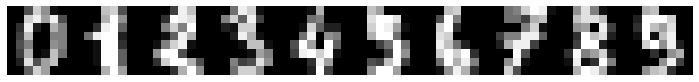

In [23]:
# load the first two classes of the digits dataset
dataset = sklearn.datasets.load_digits()
digits_x, digits_y = dataset['data'], dataset['target']

# create a binary classification problem
digits_y = (digits_y < 5).astype(float)

# plot some of the digits
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([digits_x[i].reshape(8, 8) for i in range(10)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')

# normalize the values to [0, 1]
digits_x -= np.mean(digits_x)
digits_x /= np.std(digits_x)

# print some statistics
print('digits_x.shape:', digits_x.shape)
print('digits_y.shape:', digits_y.shape)
print('min, max values:', np.min(digits_x), np.max(digits_x))
print('labels:', np.unique(digits_y))

We divide the dataset in a train and a test set.

In [24]:
# make a 50%/50% train/test split
train_prop = 0.5
n_train = int(digits_x.shape[0] * train_prop)

# shuffle the images
idxs = np.random.permutation(digits_x.shape[0])

# take a subset
x = {'train': digits_x[idxs[:n_train]],
     'test':  digits_x[idxs[n_train:]]}
y = {'train': digits_y[idxs[:n_train]],
     'test':  digits_y[idxs[n_train:]]}

print('Training samples:', x['train'].shape[0])
print('Test samples:', x['test'].shape[0])

Training samples: 898
Test samples: 899


We will now implement a function that trains the network. For each epoch, it loops over all minibatches in the training set and updates the network weights. It will then compute the loss and accuracy for the test samples. Finally, it will plot the learning curves.

**(a) Read through the code below.**

In [25]:
def fit(net, x, y, epochs=25, learning_rate=0.001, mb_size=10):
    # initialize the loss and accuracy history
    loss_hist = {'train': [], 'test': []}
    accuracy_hist = {'train': [], 'test': []}

    for epoch in range(epochs):
        # initialize the loss and accuracy for this epoch
        loss = {'train': 0.0, 'test': 0.0}
        accuracy = {'train': 0.0, 'test': 0.0}

        # first train on training data, then evaluate on the test data
        for phase in ('train', 'test'):
            # compute the number of minibatches
            steps = x[phase].shape[0] // mb_size

            # loop over all minibatches
            for step in range(steps):
                # get the samples for the current minibatch
                x_mb = x[phase][(step * mb_size):((step + 1) * mb_size)]
                y_mb = y[phase][(step * mb_size):((step + 1) * mb_size), None]

                # compute the forward pass through the network
                pred_y, trace = net.forward(x_mb)

                # compute the current loss and accuracy
                loss[phase] += np.mean(bce_loss(y_mb, pred_y))
                accuracy[phase] += np.mean((y_mb > 0.5) == (pred_y > 0.5))

                # only update the network in the training phase
                if phase == 'train':
                    # compute the gradient for the loss
                    dy = bce_loss_grad(y_mb, pred_y)

                    # backpropagate the gradient through the network
                    net.backward(trace, dy)

                    # update the weights
                    net.step(learning_rate)

            # compute the mean loss and accuracy over all minibatches
            loss[phase] = loss[phase] / steps
            accuracy[phase] = accuracy[phase] / steps

            # add statistics to history
            loss_hist[phase].append(loss[phase])
            accuracy_hist[phase].append(accuracy[phase])

        print('Epoch %3d: loss[train]=%7.4f  accuracy[train]=%7.4f  loss[test]=%7.4f  accuracy[test]=%7.4f' %
              (epoch, loss['train'], accuracy['train'], loss['test'], accuracy['test']))

    # plot the learning curves
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    for phase in loss_hist:
        plt.plot(loss_hist[phase], label=phase)
    plt.title('BCE loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for phase in accuracy_hist:
        plt.plot(accuracy_hist[phase], label=phase)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

We will define a two-layer network:
* A linear layer that maps the 64 features of the input to 32 features.
* A ReLU activation function.
* A linear layer that maps the 32 features to the 1 output features.
* A sigmoid activation function that maps the output to [0, 1].

**(b) Train the network and inspect the results. Tune the hyperparameters to get a good result.<span style="float:right"> (1 point)</span>**

Epoch   0: loss[train]= 0.8775  accuracy[train]= 0.7303  loss[test]= 0.7390  accuracy[test]= 0.8427
Epoch   1: loss[train]= 0.6544  accuracy[train]= 0.8685  loss[test]= 0.5731  accuracy[test]= 0.8775
Epoch   2: loss[train]= 0.5318  accuracy[train]= 0.8888  loss[test]= 0.4853  accuracy[test]= 0.8921
Epoch   3: loss[train]= 0.4593  accuracy[train]= 0.9011  loss[test]= 0.4303  accuracy[test]= 0.9022
Epoch   4: loss[train]= 0.4093  accuracy[train]= 0.9146  loss[test]= 0.3926  accuracy[test]= 0.9157
Epoch   5: loss[train]= 0.3719  accuracy[train]= 0.9202  loss[test]= 0.3637  accuracy[test]= 0.9258
Epoch   6: loss[train]= 0.3421  accuracy[train]= 0.9247  loss[test]= 0.3403  accuracy[test]= 0.9292
Epoch   7: loss[train]= 0.3171  accuracy[train]= 0.9337  loss[test]= 0.3206  accuracy[test]= 0.9326
Epoch   8: loss[train]= 0.2954  accuracy[train]= 0.9393  loss[test]= 0.3036  accuracy[test]= 0.9326
Epoch   9: loss[train]= 0.2763  accuracy[train]= 0.9438  loss[test]= 0.2885  accuracy[test]= 0.9348


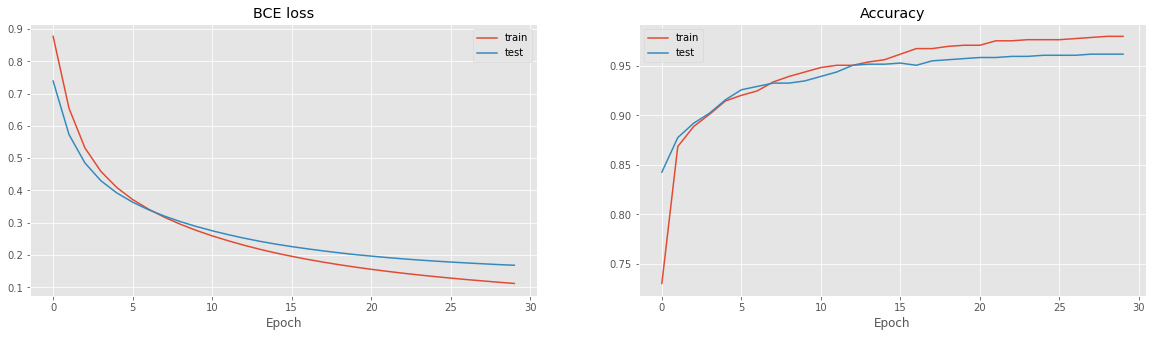

In [26]:
# construct network
net = Net([
        Linear(64, 32),
        ReLU(),
        Linear(32, 1),
        Sigmoid()])

fit(net, x, y,
    epochs = 30,
    learning_rate = 0.001,
    mb_size = 10)

# Note: add more cells below if you want to keep runs with different hyperparameters. Make sure to also copy the network construction.

**(c) How did each of the hyperparameters (number of epochs, learning rate, minibatch size) influence your results? How important is it to set each correctly?<span style="float:right"> (1 point)</span>**

The learning rate is the one that most impacts the results, the number of epochs can slightly increase or decrease the accuracy, but after more than 10 epochs, the change is less significant. The minibatch size has barely no impact on the accuracy when the other parameters are tuned.

**(d) Create and train a network with one linear layer followed by a sigmoid activation:<span style="float:right"> (1 point)</span>**

`net = Net([Linear(...), Sigmoid()]`

Epoch   0: loss[train]= 0.8650  accuracy[train]= 0.6640  loss[test]= 0.7990  accuracy[test]= 0.7191
Epoch   1: loss[train]= 0.6763  accuracy[train]= 0.8225  loss[test]= 0.6867  accuracy[test]= 0.8079
Epoch   2: loss[train]= 0.5965  accuracy[train]= 0.8551  loss[test]= 0.6266  accuracy[test]= 0.8326
Epoch   3: loss[train]= 0.5509  accuracy[train]= 0.8663  loss[test]= 0.5891  accuracy[test]= 0.8416
Epoch   4: loss[train]= 0.5209  accuracy[train]= 0.8775  loss[test]= 0.5633  accuracy[test]= 0.8528
Epoch   5: loss[train]= 0.4993  accuracy[train]= 0.8820  loss[test]= 0.5445  accuracy[test]= 0.8551
Epoch   6: loss[train]= 0.4829  accuracy[train]= 0.8876  loss[test]= 0.5301  accuracy[test]= 0.8607
Epoch   7: loss[train]= 0.4699  accuracy[train]= 0.8921  loss[test]= 0.5185  accuracy[test]= 0.8652
Epoch   8: loss[train]= 0.4592  accuracy[train]= 0.8978  loss[test]= 0.5091  accuracy[test]= 0.8663
Epoch   9: loss[train]= 0.4502  accuracy[train]= 0.8978  loss[test]= 0.5012  accuracy[test]= 0.8708


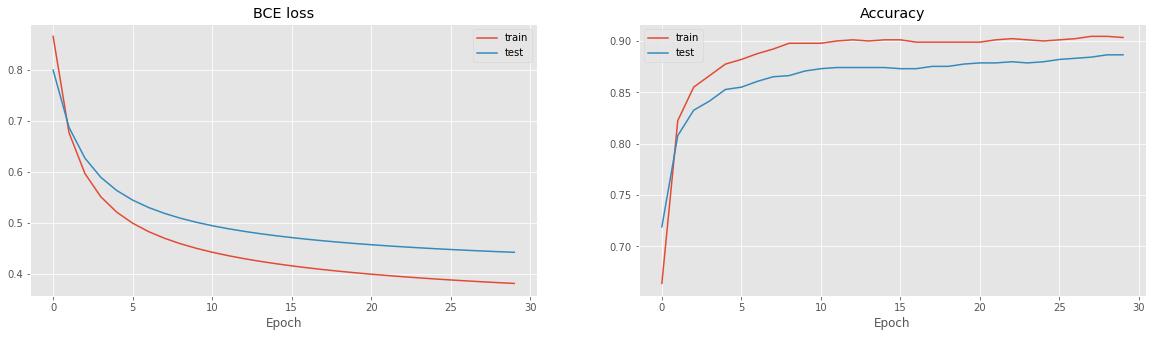

In [ ]:
net = Net([
        Linear(64, 1),
        Sigmoid()])

fit(net, x, y,
    epochs = 30,
    learning_rate = 0.001,
    mb_size = 10)

**(e) Discuss your results. Compare the results of this single-layer network with those of the network you trained before.<span style="float:right"> (1 point)</span>**

The accuracy is approximately 10% lower than the previous one, which menas that the additional layer was a necessary improvement for obtaining a better result. 

**(f) Repeat the experiment with a network with two linear layers, followed by a sigmoid activation: `[Linear, Linear, Sigmoid]`.<span style="float:right"> (1 point)</span>**

Epoch   0: loss[train]= 0.8028  accuracy[train]= 0.7416  loss[test]= 0.6350  accuracy[test]= 0.8461
Epoch   1: loss[train]= 0.5886  accuracy[train]= 0.8584  loss[test]= 0.5302  accuracy[test]= 0.8685
Epoch   2: loss[train]= 0.5174  accuracy[train]= 0.8674  loss[test]= 0.4832  accuracy[test]= 0.8719
Epoch   3: loss[train]= 0.4798  accuracy[train]= 0.8753  loss[test]= 0.4566  accuracy[test]= 0.8809
Epoch   4: loss[train]= 0.4557  accuracy[train]= 0.8809  loss[test]= 0.4393  accuracy[test]= 0.8809
Epoch   5: loss[train]= 0.4387  accuracy[train]= 0.8876  loss[test]= 0.4271  accuracy[test]= 0.8843
Epoch   6: loss[train]= 0.4260  accuracy[train]= 0.8921  loss[test]= 0.4182  accuracy[test]= 0.8854
Epoch   7: loss[train]= 0.4162  accuracy[train]= 0.8933  loss[test]= 0.4115  accuracy[test]= 0.8843
Epoch   8: loss[train]= 0.4086  accuracy[train]= 0.8955  loss[test]= 0.4064  accuracy[test]= 0.8843
Epoch   9: loss[train]= 0.4025  accuracy[train]= 0.8955  loss[test]= 0.4024  accuracy[test]= 0.8831


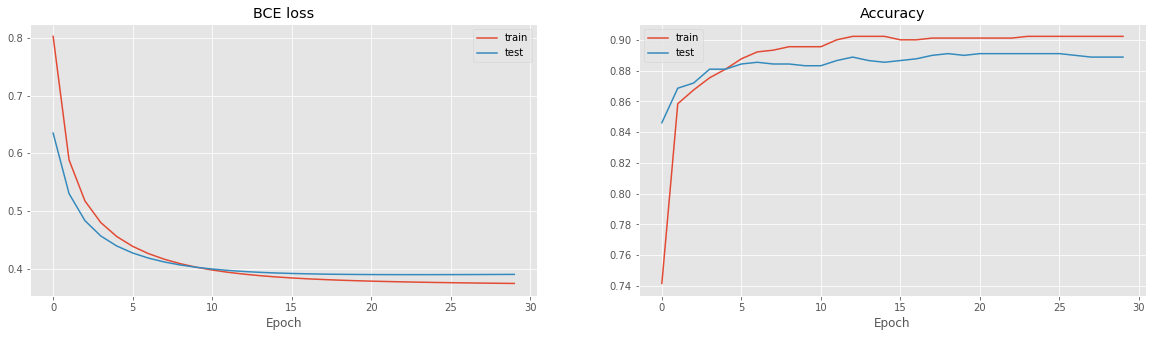

In [27]:
# construct network
net = Net([
        Linear(64, 32),
        Linear(32, 1),
        Sigmoid()])
fit(net, x, y,
    epochs = 30,
    learning_rate = 0.001,
    mb_size = 10)

**(g) How does the performance of this network compare with the previous networks. Can you explain this result? What is the influence of the activation functions in the network?<span style="float:right"> (1 point)</span>**

Both accuracy and loss are similar to the ones corresponding to the single linear layer. The absence of an activation function in this case makes having two linear layers similar to have only one.

**(h) One way to improve the performance of a neural network is by increasing the number of layers. Try a deeper network (e.g., a network with four linear layers) to see if this outperforms the previous networks.<span style="float:right"> (1 point)</span>**

Epoch   0: loss[train]= 1.0118  accuracy[train]= 0.5213  loss[test]= 1.0017  accuracy[test]= 0.5045
Epoch   1: loss[train]= 0.7892  accuracy[train]= 0.7348  loss[test]= 0.6601  accuracy[test]= 0.7944
Epoch   2: loss[train]= 0.3883  accuracy[train]= 0.8989  loss[test]= 0.2217  accuracy[test]= 0.9494
Epoch   3: loss[train]= 0.2844  accuracy[train]= 0.9247  loss[test]= 0.2201  accuracy[test]= 0.9472
Epoch   4: loss[train]= 0.1692  accuracy[train]= 0.9652  loss[test]= 0.1687  accuracy[test]= 0.9596
Epoch   5: loss[train]= 0.1400  accuracy[train]= 0.9697  loss[test]= 0.1409  accuracy[test]= 0.9719
Epoch   6: loss[train]= 0.1157  accuracy[train]= 0.9742  loss[test]= 0.1871  accuracy[test]= 0.9584
Epoch   7: loss[train]= 0.1286  accuracy[train]= 0.9742  loss[test]= 0.1784  accuracy[test]= 0.9573
Epoch   8: loss[train]= 0.1055  accuracy[train]= 0.9775  loss[test]= 0.1522  accuracy[test]= 0.9652
Epoch   9: loss[train]= 0.1145  accuracy[train]= 0.9787  loss[test]= 0.1850  accuracy[test]= 0.9596


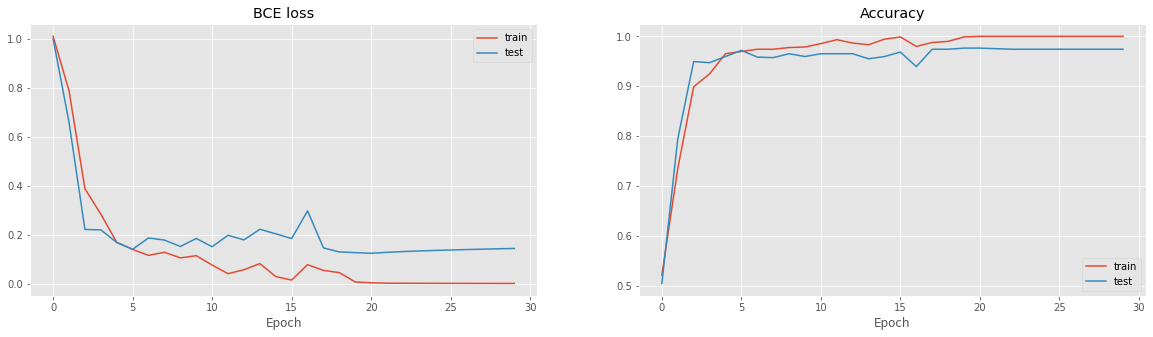

In [28]:
net = Net([
        Linear(64, 32),
        ReLU(),
        Linear(32, 16),
        ReLU(),
        Linear(16, 8),
        Sigmoid(),
        Linear(8, 1),
        Sigmoid()])
fit(net, x, y,
    epochs = 30,
    learning_rate = 0.03,
    mb_size = 10)

**(i) Discuss your findings. Were you able to obtain a perfect classification? Explain the learning curves.<span style="float:right"> (1 point)</span>**

It was possible to obtain a classification with a 2% better accuracy than the previous one. It is a significant improvement given that there was not much room for it, yet it may not be worth to duplicate the layers just for a 2% better accuracy.

## 1.7 Final questions (6 points)

You now have some experience training neural networks. Time for a few final questions.

**(a) What is the influence of the learning rate? What happens if the learning rate is too low or too high?<span style="float:right"> (2 points)</span>**

The learning rate must have a proper pace for reaching a good accuracy. If it is too low, it may not reach it, but if it is too high, it will not get a precise result when reaching it. 

**(b) What is the role of the minibatch size in SGD? Explain the downsides of a minibatch size that is too small or too high.<span style="float:right"> (2 points)</span>**

The minibatch allows to compute the parameters more frequently, limiting the processing to just a subset of the whole dataset. Different batches are used in each iteration, so there is no discarded information in the process. If the minibatch size is too small, it may struggle to achieve convergence, while if it is too big, its performance will be similar to the case in which the whole dataset is processed.

**(c) In the linear layer, we initialized the weights $w$ with random values, but we initialized the bias $b$ with zeros. What would happen if the weights $w$ were initialised as zeros? Why is this not a problem for the bias?<span style="float:right"> (2 points)</span>**

If all the weights are zero, all the neurons would cancel out the variables and generate the same result. When setting random weights we're already ensuring the neuron will work differently from each other, thus the bias added can begin with a zero value and later change during the training. 

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 45 points.*